# KNO for 2D Navier-Stokes

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindflow/en/data_driven/mindspore_navier_stokes_KNO2D.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindflow/en/data_driven/mindspore_navier_stokes_KNO2D.py)&emsp;[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_en/data_driven/navier_stokes_KNO2D.ipynb)

## Overview

Computational fluid dynamics is one of the most important techniques in the field of fluid mechanics in the 21st century. The flow analysis, prediction and control can be realized by solving the governing equations of fluid mechanics by numerical method. Traditional finite element method (FEM) and finite difference method (FDM) are inefficient because of the complex simulation process (physical modeling, meshing, numerical discretization, iterative solution, etc.) and high computing costs. Therefore, it is necessary to improve the efficiency of fluid simulation with AI.

Machine learning methods provide a new paradigm for scientific computing by providing a fast solver similar to traditional methods. Classical neural networks learn mappings between finite dimensional spaces and can only learn solutions related to specific discretizations. Different from traditional neural networks, Fourier Neural Operator (FNO) is a new deep learning architecture that can learn mappings between infinite-dimensional function spaces. It directly learns mappings from arbitrary function parameters to solutions to solve a class of partial differential equations.  Therefore, it has a stronger generalization capability. More information can be found in the paper, [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/abs/2010.08895).

But these kinds of neural operator become less accurate and explainable while learning long-term behaviours of non-linear PDE families. Koopman neural operator (KNO), a new neural operator, overcome these challenges by formulating a non-linear dynamic system of equation solution. By approximating the Koopman operator, an infnite-dimensional linear operator governing all possible observations of the dynamic system, to act on the flow mapping of dynamic system, we can equivalently learn the solution of an entire non-linear PDE family by solving simple linear prediction problems. More information can be found in these papers:

- "[Koopman neural operator as a mesh-free solver of non-linear partial differential equations](https://arxiv.org/abs/2301.10022)." arXiv preprint arXiv:2301.10022 (2023).
- "[KoopmanLab: machine learning for solving complex physics equations](https://arxiv.org/abs/2301.01104)." arXiv preprint arXiv:2301.01104 (2023).

This tutorial describes how to solve the Navier-Stokes equation using Koopman neural operator.

## Navier-Stokes equation

Navier-Stokes equation is a classical equation in computational fluid dynamics. It is a set of partial differential equations describing the conservation of fluid momentum, called N-S equation for short. Its vorticity form in two-dimensional incompressible flows is as follows:

$$
\partial_t w(x, t)+u(x, t) \cdot \nabla w(x, t)=\nu \Delta w(x, t)+f(x), \quad x \in(0,1)^2, t \in(0, T]
$$

$$
\nabla \cdot u(x, t)=0, \quad x \in(0,1)^2, t \in[0, T]
$$

$$
w(x, 0)=w_0(x), \quad x \in(0,1)^2
$$

where $u$ is the velocity field, $w=\nabla \times u$ is the vorticity, $w_0(x)$ is the initial vorticity, $\nu$ is the viscosity coefficient, $f(x)$ is the forcing function.

## Problem Description

We aim to solve two-dimensional incompressible N-S equation by learning the operator mapping from each time step to the next time step:

$$
w_t \mapsto w(\cdot, t+1)
$$

## Technology Path

MindSpore Flow solves the problem as follows:

1. Training Dataset Construction.
2. Model Construction.
3. Optimizer and Loss Function.
4. Model Training.
5. Model Evaluation and Visualization.

## Koopman Neural Operator

The following figure shows the architecture of the Koopman Neural Operator, which contains the upper and lower main branches and corresponding outputs. In the figure, Input represents the initial vorticity. In the upper branch, the input vector is lifted to higher dimension channel space by the Encoding layer. Then the mapping result is used as the input of the Koopman layer to perform nonlinear transformation of the frequency domain information. Finally, the Decoding layer maps the transformation result to the Prediction. At the same time, the lower branch does high-dimensional mapping of the input vector through the Encoding Layer, and then reconstructs the input through the Decoding Layer. The Encoding layers of the upper and lower branches share the weight, and the Decoding layers share the weight too. Prediction is used to calculate the prediction error with Label, and Reconstruction is used to calculate the reconstruction error with Input. The two errors together guide the gradient calculation of the model.

The Koopman Neural Operator consists of the Encoding Layer, Koopman Layers, Decoding Layer and two branches.

The Koopman Layer is shown in the dotted box, which could be repeated. Start from input: apply the Fourier transform(FFT); apply a linear transformation on the lower Fourier modes and filters out the higher modes; then apply the inverse Fourier transform(iFFT). Then the output is added into input. Finally, the Koopman Layer output vector is obtained through the activation function.

![Fourier Layer structure](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindflow/docs/source_en/data_driven/images/kno.jpg)

In [2]:
import os
import time
import datetime
import numpy as np

import mindspore
from mindspore import nn, context, ops, Tensor, set_seed, dtype
from mindspore.nn import MSELoss

from mindflow.cell import KNO2D
from mindflow.common import get_warmup_cosine_annealing_lr
from mindflow.utils import load_yaml_config

The following `src` pacakage can be downloaded in [applications/data_driven/navier_stokes/kno2d/src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/data_driven/navier_stokes/kno2d/src).

In [3]:
from src.dataset import create_training_dataset
from src.trainer import NavierStokesWithLoss
from src.utils import visual

set_seed(0)
np.random.seed(0)

print("pid:", os.getpid())
print(datetime.datetime.now())

context.set_context(mode=context.GRAPH_MODE, device_target='Ascend', device_id=4)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"

pid: 184534
2023-03-04 07:39:18.207815


You can get hyperparameters of model, data and optimizer from [config](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/applications/data_driven/navier_stokes/kno2d/configs/kno2d.yaml).

In [4]:
config = load_yaml_config('navier_stokes_2d.yaml')
data_params = config["data"]
model_params = config["model"]
optimizer_params = config["optimizer"]

## Training Dataset Construction

Download the training and test dataset: [data_driven/navier_stokes/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/data_driven/navier_stokes/dataset/).

In this case, training data sets and test data sets are generated according to Zongyi Li's data set in [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/pdf/2010.08895.pdf). The settings are as follows:

The initial condition $w_0(x)$ is generated according to periodic boundary conditions:

$$
w_0 \sim \mu, \mu=\mathcal{N}\left(0,7^{3 / 2}(-\Delta+49 I)^{-2.5}\right)
$$

The forcing function is defined as:

$$
f(x)=0.1\left(\sin \left(2 \pi\left(x_1+x_2\right)\right)+\right.\cos(2 \pi(x_1+x_2)))
$$

We use a time-step of 1e-4 for the Crank–Nicolson scheme in the data-generated process where we record the solution every t = 1 time units. All data are generated on a 256 × 256 grid and are downsampled to 64 × 64. In this case, the viscosity coefficient $\nu=1e-5$, the number of samples in the training set is 19000, and the number of samples in the test set is 3800.

In [5]:
# create training dataset
train_dataset = create_training_dataset(data_params, shuffle=True)
test_input = np.load(os.path.join(data_params["path"], "test/inputs.npy"))
test_label = np.load(os.path.join(data_params["path"], "test/label.npy"))
print('test_input: ', test_input.shape)
print('test_label: ', test_label.shape)

Data preparation finished
input_path:  (19000, 64, 64, 1, 1)
label_path:  (19000, 64, 64, 1, 1)
test_input:  (200, 19, 64, 64, 1, 1)
test_label:  (200, 19, 64, 64, 1, 1)


## Model Construction

The network is composed of 1 shared Encoding Layer, multiple Koopman Layers and 1 shared Decoding Layer:

- The Encoding Layer corresponds to the `KNO2D.enc` in the case, and maps the output data to the high dimension;

- Koopman Layer corresponds to the `KNO2D.koopman_layer` in the case. Discrete Fourier transform is used to realize the conversion between time domain and frequency domain;

- The Decoding Layer corresponds to `KNO2D.dec` in the case to obtain the final predictive value.

In [7]:
model = KNO2D(in_channels=data_params['in_channels'],
              channels=model_params['channels'],
              modes=model_params['modes'],
              depths=model_params['depths'],
              resolution=model_params['resolution'],
              compute_dtype=dtype.float16 if use_ascend else dtype.float32
              )

model_params_list = []
for k, v in model_params.items():
    model_params_list.append(f"{k}:{v}")
model_name = "_".join(model_params_list)
print(model_name)

name:KNO2D_channels:20_modes:16_depths:4_resolution:64


## Optimizer and Loss Function

Use the mean square error as the training loss function:

In [8]:
train_size = train_dataset.get_dataset_size()

lr = get_warmup_cosine_annealing_lr(lr_init=optimizer_params["lr"],
                                    last_epoch=optimizer_params["epochs"],
                                    steps_per_epoch=train_size,
                                    warmup_epochs=1)
optimizer = nn.AdamWeightDecay(model.trainable_params(),
                               learning_rate=Tensor(lr),
                               weight_decay=optimizer_params["weight_decay"])
model.set_train()
loss_fn = MSELoss()
if use_ascend:
    from mindspore.amp import DynamicLossScaler, auto_mixed_precision, all_finite
    loss_scaler = DynamicLossScaler(1024, 2, 100)
    auto_mixed_precision(model, 'O3')
else:
    loss_scaler = None

## Model Training

With **MindSpore version >= 2.0.0**, we can use the functional programming for training neural networks.

In [9]:
problem = NavierStokesWithLoss(model, data_params["out_channels"], loss_fn, data_format="NHWTC")

def forward_fn(inputs, labels):
    loss, l_recons, l_pred = problem.get_loss(inputs, labels)
    if use_ascend:
        loss = loss_scaler.scale(loss)
    return loss, l_recons, l_pred

grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

def train_step(inputs, labels):
    (loss, l_recons, l_pred), grads = grad_fn(inputs, labels)
    if use_ascend:
        loss = loss_scaler.unscale(loss)
        if all_finite(grads):
            grads = loss_scaler.unscale(grads)
    loss = ops.depend(loss, optimizer(grads))
    return loss, l_recons, l_pred

train_sink = mindspore.data_sink(train_step, train_dataset, sink_size=1)

summary_dir = os.path.join(config["summary_dir"], model_name)
os.makedirs(summary_dir, exist_ok=True)
print(summary_dir)

for epoch in range(1, optimizer_params["epochs"] + 1):
    time_beg = time.time()
    train_recons_full = 0.0
    train_pred_full = 0.0
    for _ in range(train_size):
        _, l_recons, l_pred = train_sink()
        train_recons_full += l_recons.asnumpy()
        train_pred_full += l_pred.asnumpy()
    train_recons_full = train_recons_full / train_size
    train_pred_full = train_pred_full / train_size
    print(f"epoch: {epoch}, time cost: {(time.time() - time_beg):>8f},"
          f" recons loss: {train_recons_full:>8f}, pred loss: {train_pred_full:>8f}")

    if epoch % config['eval_interval'] == 0:
        l_recons_all, l_pred_all = problem.test(test_input, test_label)
        print(f'Eval epoch: {epoch}, recons loss: {l_recons_all}, relative pred loss: {l_pred_all}')
        mindspore.save_checkpoint(model, ckpt_file_name=summary_dir + '/save_model.ckpt')

./summary_dir/name:KNO2D_channels:20_modes:16_depths:4_resolution:64


epoch: 1, time cost: 55.562426, recons loss: 0.467314, pred loss: 0.237300
epoch: 2, time cost: 32.804436, recons loss: 0.175188, pred loss: 0.050888
epoch: 3, time cost: 32.946971, recons loss: 0.167865, pred loss: 0.041778
epoch: 4, time cost: 33.064430, recons loss: 0.170181, pred loss: 0.038075
epoch: 5, time cost: 32.907211, recons loss: 0.171853, pred loss: 0.035849
epoch: 6, time cost: 33.799230, recons loss: 0.173322, pred loss: 0.034017
epoch: 7, time cost: 32.612255, recons loss: 0.174376, pred loss: 0.032719
epoch: 8, time cost: 32.896673, recons loss: 0.175445, pred loss: 0.031596
epoch: 9, time cost: 33.907305, recons loss: 0.176131, pred loss: 0.030644
epoch: 10, time cost: 33.175130, recons loss: 0.176701, pred loss: 0.029969
Eval epoch: 10, recons loss: 0.23137304687500002, relative pred loss: 0.03798459614068269

...

epoch: 41, time cost: 32.962233, recons loss: 0.185430, pred loss: 0.017872
epoch: 42, time cost: 33.296847, recons loss: 0.185595, pred loss: 0.017749
e

## Model Evaluation and Visualization

Take 1 samples, and do 10 consecutive steps of prediction. Visualize the prediction as follows.

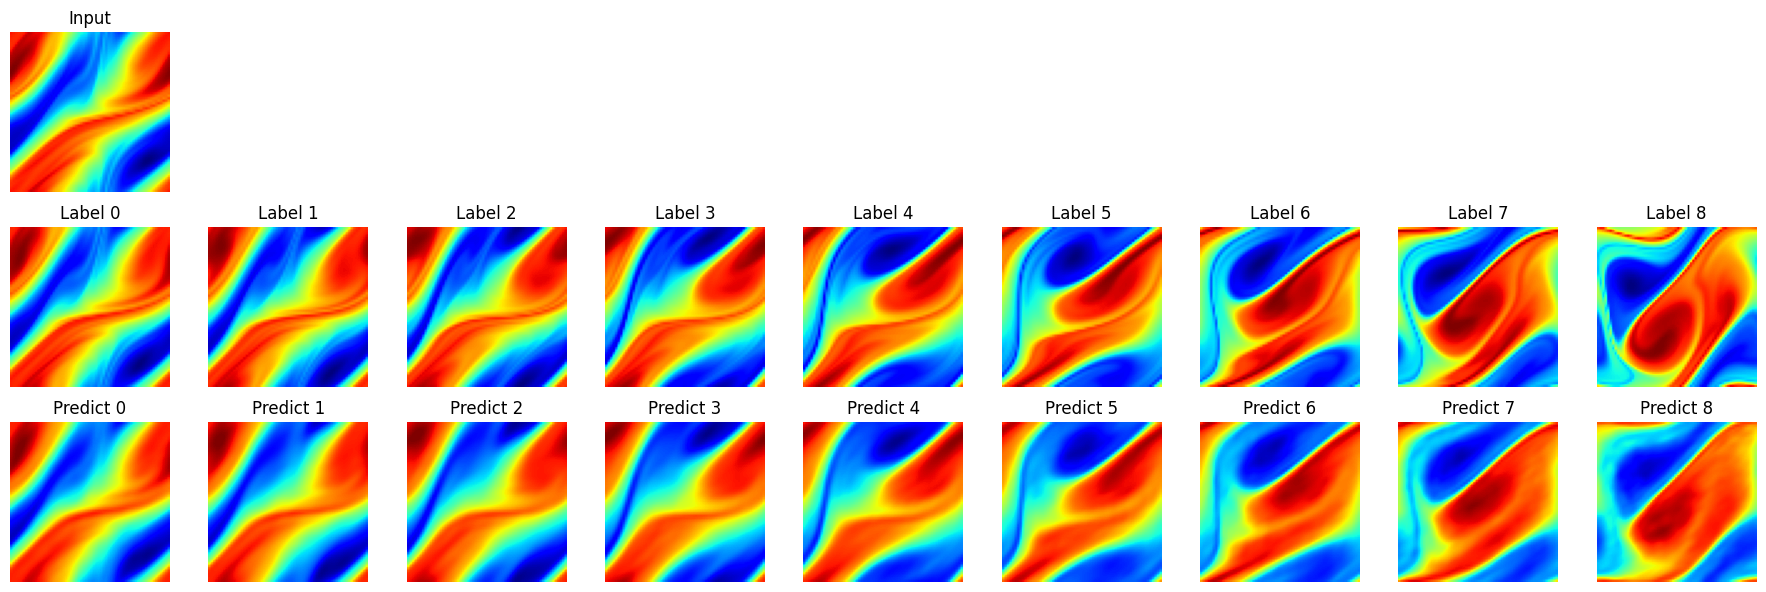

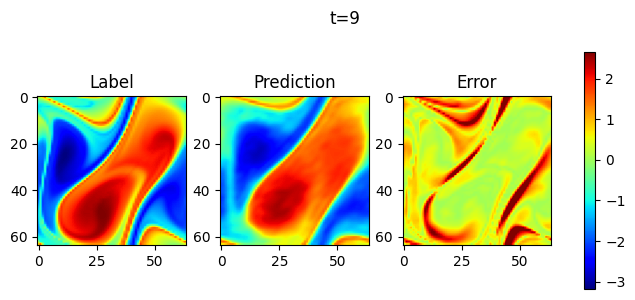

In [13]:
# Infer and plot some data.
visual(problem, test_input, test_label, t_out=10)